In [1]:
import pandas as pd
from pathlib import Path
import inspect 
import numpy as np
import datetime
import os
import json
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from dotmap import DotMap
import torch
import torch.nn.init as init
import torch.nn as nn
import pickle
import torch.autograd as autograd
from torchviz import make_dot
from torchsummary import summary
from termcolor import colored
import seaborn as sns
sns.set()


from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics.pairwise import rbf_kernel
from scipy.stats import wasserstein_distance, entropy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
reserved = int(torch.cuda.max_memory_reserved() / 1000 / 1000)
gpu_available = torch.cuda.is_available()

print(colored(f"GPU available! {torch.cuda.get_device_name()}. Memory reserved: {reserved}MB", "green") if gpu_available else colored("No GPU. Running on CPU", "red"))

GPU available! NVIDIA GeForce RTX 3060. Memory reserved: 0MB


## Research Notes and Progress

**Current Status**
1. Should we do $X_{t0} \rightarrow NEE_{t1}$ instead of current $X_{t0} \rightarrow NEE_{t0}$ and see if we beat RFR at this
2. MSE experiments
3. Architecture experiments

In [3]:
timestamp = datetime.datetime.now()
timestamp = f"{timestamp.year}-{timestamp.month}-{timestamp.day}_{timestamp.hour}-{timestamp.minute}-{timestamp.second}-{timestamp.microsecond}"

save_dir = Path(timestamp)
if save_dir.exists():
    raise f"Directory exists: {save_dir.as_posix()}"
os.makedirs(save_dir.as_posix())

In [4]:
config = DotMap({"flux_model": "night", "model_type:": "VAE"})

In [5]:
writer = SummaryWriter(save_dir.joinpath("tensorboard"))

## Model Building and Training

### Data

In [6]:
data = pd.read_parquet("../data_manipulation/final_night_data.parquet")

In [7]:
def set_season_tag(df, isnorth = True):
    if isnorth:
        df["season"] = (df['DateTime'].dt.month%12 + 3) // 3 # print(seasons)
    else:
        df["season"] = ((df['DateTime'].dt.month + 6)%12 + 3)//3
    return df, "season"

def extract_time_features(df):
    """
    Extract features from the timestamp for model training.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Timestamp' and 'NEE' columns.
    
    Returns:
    pd.DataFrame: DataFrame with extracted features, list: features added to dataframe
    """
    df = df.copy()
    df['hour'] = df['DateTime'].dt.hour
    df['dayofweek'] = df['DateTime'].dt.dayofweek
    df['month'] = df['DateTime'].dt.month
    df['dayofyear'] = df['DateTime'].dt.dayofyear
    return df, ["hour", "dayofweek", "month", "dayofyear"]
    
def split_data(df, test_size=0.2):
    """
    Split data into training and test sets.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Timestamp' and 'NEE' columns.
    test_size (float): Proportion of the data to include in the test split.
    
    Returns:
    tuple: Training and test DataFrames.
    """
    train_data, test_data = train_test_split(df, test_size=test_size, shuffle=False)
    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)

In [8]:
drivers = np.array(['Ta', 'H', 'Tau', 'LE_strg', 'RH', 'VPD', 'Rg', 'Ustar', 'Tsoil1', 'Tsoil2'])

In [9]:
data, season_feat = set_season_tag(data)
data, time_feat = extract_time_features(data)

In [10]:
data = data[data["dNEE"].notna()].reset_index(drop=True)

In [11]:
data.shape

(21535, 76)

In [12]:
drivers = np.concatenate([drivers, [season_feat], time_feat])

In [13]:
columns_to_check_na = np.concatenate([drivers, ["NEE", "dTa"]])

idx = (np.sum(data[columns_to_check_na].notna(), axis=1) == columns_to_check_na.shape[0])
data = data.loc[idx].reset_index(drop=True)

### Training Data 

In [14]:
train_data, test_data = split_data(data)

In [15]:
drivers = np.append(drivers, ["NEE", "E0", "rb"])

In [16]:
X_train = train_data[drivers]
NEE_train = train_data["NEE_next"]
dT_train = train_data["dTa"]
dNEE_train = train_data["dNEE"]
bNEE_train = train_data["NEE"]
K_train = train_data[["E0", "rb"]]

X_test = test_data[drivers]
NEE_test = test_data["NEE_next"]
dT_test = test_data["dTa"]
dNEE_test = test_data["dNEE"]
bNEE_test = test_data["NEE"]
K_test = test_data[["E0", "rb"]]


In [17]:
normalizer = StandardScaler()

X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

In [18]:
with open(save_dir.joinpath("normalizer.pickle"), "wb") as fp:
    pickle.dump(normalizer, fp)

In [19]:
config.data.X = drivers.tolist()
config.data.train_size = X_train.shape[0]
config.data.train_start_date = train_data["DateTime"].iloc[0].ctime()
config.data.train_end_date = train_data["DateTime"].iloc[-1].ctime()
config.data.test_size = X_test.shape[0]
config.data.test_start_date = test_data["DateTime"].iloc[0].ctime()
config.data.test_end_date = test_data["DateTime"].iloc[-1].ctime()


### Model Building

In [20]:
def initialize_weights(layer):
    if isinstance(layer, nn.Linear):
        # Apply He initialization
        init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
        init.zeros_(layer.bias)

In [21]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, encoder_dims, decoder_dims, activation=nn.Tanh, hard_z=False):
        super(VAE, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.activation = activation
        self.Tref = torch.tensor(10).to("cuda")
        self.T0 = torch.tensor(46.02).to("cuda")
        self.encoder_dims = encoder_dims
        self.decoder_dims = decoder_dims
        self.hard_z = hard_z
        
        # Encoder network
        modules = self.append_linear_modules(self.input_dim, self.encoder_dims)
        print(modules)
        self.encoder = nn.Sequential(*modules)

        self.fc_mu = nn.Sequential(nn.Linear(self.encoder_dims[-1], latent_dim), activation())
        self.fc_logvar = nn.Sequential(nn.Linear(self.encoder_dims[-1], latent_dim), activation())
        
       # Decoder network for NEE (u)
        modules = self.append_linear_modules(self.latent_dim, self.decoder_dims) 
        modules.append(nn.Linear(self.decoder_dims[-1], 1))
        self.nee_decoder = nn.Sequential(*modules)

        # Decoder network for E0 and rb
        modules = self.append_linear_modules(self.latent_dim, self.decoder_dims) 
        modules.append(nn.Linear(self.decoder_dims[-1], 2))
        self.k_decoder = nn.Sequential(*modules)
        

    def append_linear_modules(self, in_dim, dims):
        modules = []
        for i, dim in enumerate(dims):
            modules.append(nn.Linear(in_dim, dim))
            if i != len(dims) - 1:
                modules.append(self.activation())
            in_dim = dim
        return modules
        
    def reparameterize(self, mu, logvar):
        if self.hard_z:
            return mu
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        k = self.k_decoder(z)
        
        nee = self.nee_decoder(z)
        
        return nee, k, z


In [22]:
def loss_function(nee_pred, nee_true, latent, z_prior, k_pred, k_true, loss_fn):
    # MMD Loss for NEE (u)
    mmd_loss_nee = loss_fn(nee_pred, nee_true) + loss_fn(latent, z_prior)

    # MMD Loss for E0 and rb (k)
    E0_pred, rb_pred = k_pred[:, 0], k_pred[:, 1]
    E0_true, rb_true = k_true[:, 0], k_true[:, 1]
    mmd_loss_E0 = loss_fn(E0_pred.view((-1, 1)), E0_true.view((-1, 1)))
    mmd_loss_rb = loss_fn(rb_pred.view((-1, 1)), rb_true.view((-1, 1)))

    return mmd_loss_nee, mmd_loss_E0, mmd_loss_rb


In [23]:
class MMD_loss(nn.Module):
    'description'
    # function class which calculates the MMD distance of 2 distributions

    def __init__(self, kernel_mul = 2.0, kernel_num = 5):
        super(MMD_loss, self).__init__()

        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        return
    
    def guassian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0])+int(target.size()[0])
        total = torch.cat([source, target], dim=0)

        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2) 
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)

    def forward(self, source, target):
        batch_size = int(source.size()[0])
        kernels = self.guassian_kernel(source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        loss = torch.mean(XX + YY - XY -YX)
        return loss

In [24]:
class ClimateDataset(Dataset):
    def __init__(self, X, k, dNEE, bNEE, dT, NEE):
        """
        Args:
            X (numpy array): Input data of shape (n_samples, input_dim)
            k (numpy array): Ground truth for E0 and rb, shape (n_samples, 2)
            dNEE (numpy array): Ground truth for f, shape (n_samples, 1)
            bNEE (numpy array): Ground truth for NEE at current t (boundary condition), shape (n_samples, 1)
            dT (numpy array): Ground truth for temperature derivative, shape (n_samples, 1)
            NEE (numpy array): Ground truth for NEE at t + 1, shape (n_samples, 1)
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.k = torch.tensor(k, dtype=torch.float32)
        self.dNEE = torch.tensor(dNEE, dtype=torch.float32)
        self.bNEE = torch.tensor(NEE, dtype=torch.float32)
        self.dT = torch.tensor(dT, dtype=torch.float32)
        self.NEE = torch.tensor(NEE, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # Get current NEE and previous NEE for boundary condition
        NEE_current = self.NEE[idx]
        
        return {
            'X': self.X[idx],
            'k': self.k[idx],
            'dNEE': self.dNEE[idx],
            'bNEE': self.bNEE[idx],
            'dT': self.dT[idx],
            'NEE': NEE_current
        }


### Training Setup

In [25]:
num_epochs = 1000
lr = 1e-3

model = VAE(input_dim=X_train.shape[1], latent_dim=32, encoder_dims=[16, 16], decoder_dims = [16, 16], activation=nn.ReLU)
model.apply(initialize_weights)
with open(save_dir.joinpath("model.txt"), "w") as fp:
    fp.write(str(model))

model.to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Assuming X, k, dNEE, dT, and NEE are numpy arrays you have
train_dataset = ClimateDataset(X_train, K_train.values, dNEE_train.values, bNEE_train.values, dT_train.values, NEE_train.values)
test_dataset = ClimateDataset(X_test, K_test.values, dNEE_test.values, bNEE_test.values, dT_test.values, NEE_test.values)

# Create a DataLoader instance
train_data_loader = DataLoader(train_dataset, batch_size=256, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

[Linear(in_features=18, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True)]


In [26]:
model

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=18, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
  )
  (fc_mu): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
  )
  (fc_logvar): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
  )
  (nee_decoder): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
  (k_decoder): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [27]:
loss_fn = MMD_loss()

config.model.activation = str(model.activation)
config.model.lr = lr
config.model.loss_fn = str(loss_fn)

with open(save_dir.joinpath("loss_function.txt"), "w") as fp:
    fp.write(inspect.getsource(loss_function))

In [28]:
for batch in train_data_loader:
    x = batch['X'].to("cuda")
    k = batch['k'].to("cuda")
    f = batch['dNEE'].to("cuda")
    b = batch['bNEE'].to("cuda")
    yhat = model(x)
    break
make_dot(yhat, params=dict(list(model.named_parameters()))).render(save_dir.joinpath("vae"), format="png")

'2024-8-31_15-9-54-964844/vae.png'

In [29]:
patience = 50
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience)

config.training.patience = patience
config.training.num_epochs = num_epochs

In [30]:
with open(save_dir.joinpath("config.json"), "w") as fp:
    json.dump(config.toDict(), fp)

### Training

In [31]:
best_test_loss = float('inf')
best_model_path = save_dir.joinpath('best_model.pth')

In [32]:
epoch = 0

##### Control Room

In [39]:
# CONTROL ROOM
loss_fn = MMD_loss()
model.hard_z = False
# loss_fn = nn.MSELoss()  # nn.L1Loss()
for g in optimizer.param_groups:
    g['lr'] = 0.00001

##### Back to training

In [40]:
loss_name = "MSE" if str(loss_fn) == 'MSELoss()' else "MMD"

while epoch < num_epochs:

    train_loss = []
    test_loss = []
    
    train_losses = DotMap({"mmd_loss_nee": [], "mmd_loss_E0": [], "mmd_loss_rb": [] })
    # Example of iterating over the DataLoader in the training loop
    for batch in train_data_loader:
        x = batch['X'].to("cuda")
        k = batch['k'].to("cuda")
        nee = batch['NEE'].to("cuda")
                
        nee_pred, k_pred, z = model(x)
    
        z_prior = torch.randn_like(z)
        # Compute loss
        mmd_loss_nee, mmd_loss_E0, mmd_loss_rb = loss_function(nee_pred, nee.view(-1, 1), z, z_prior, k_pred, k, loss_fn)
        loss = mmd_loss_nee + mmd_loss_E0 + mmd_loss_rb

        train_losses.mmd_loss_nee.append(mmd_loss_nee)
        train_losses.mmd_loss_E0.append(mmd_loss_E0)
        train_losses.mmd_loss_rb.append(mmd_loss_rb)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.cpu().detach().numpy())
    
    print(colored("Training Loss: {}".format(np.mean(train_loss)), "blue"))
    writer.add_scalar(f"Train Loss {loss_name}", np.mean(train_loss), epoch)
    
    for col in train_losses.keys():
        l = [x.cpu().detach().numpy() for x in train_losses[col]]
        print(col, np.mean(l), end=" ")
        writer.add_scalar(f"Train Loss [{col}] {loss_name}", np.mean(l), epoch)
    print("\n")

    test_losses = DotMap({"mmd_loss_nee": [], "mmd_loss_E0": [], "mmd_loss_rb": [] })

    for batch in test_data_loader:
        x = batch['X'].to("cuda")
        k = batch['k'].to("cuda")
        nee = batch['NEE'].to("cuda")
                
        nee_pred, k_pred, z = model(x)
        
        z_prior = torch.randn_like(z)
        # Compute loss
        mmd_loss_nee, mmd_loss_E0, mmd_loss_rb = loss_function(nee_pred, nee.view(-1, 1), z, z_prior, k_pred, k, loss_fn)
        loss = mmd_loss_nee + mmd_loss_E0 + mmd_loss_rb
        test_loss.append(loss.cpu().detach().numpy())

        test_losses.mmd_loss_nee.append(mmd_loss_nee)
        test_losses.mmd_loss_E0.append(mmd_loss_E0)
        test_losses.mmd_loss_rb.append(mmd_loss_rb)
       
    print(colored("Test Loss: {}".format(np.mean(test_loss)), "red"))
    writer.add_scalar(f"Test Loss {loss_name}", np.mean(test_loss), epoch)
    
    for col in test_losses.keys():
        l = [x.cpu().detach().numpy() for x in test_losses[col]]
        print(col, np.mean(l), end=" ")
        writer.add_scalar(f"Test Loss [{col}] {loss_name}", np.mean(l), epoch)
    print("\n\n")

    # Save best model
    if epoch % 5 == 0 and np.mean(test_loss) < best_test_loss:
            best_test_loss = np.mean(test_loss)
            torch.save(model.state_dict(), best_model_path)
            print(colored(f'New best model saved at epoch {epoch+1} with test loss: {best_test_loss:.4f}',  "light_grey"))

    scheduler.step(np.mean(test_loss))
    epoch += 1




Training Loss: 1.3980058431625366
mmd_loss_nee 0.67846966 mmd_loss_E0 0.32738814 mmd_loss_rb 0.3921482 

Test Loss: 1.4515786170959473
mmd_loss_nee 0.7234402 mmd_loss_E0 0.27120683 mmd_loss_rb 0.45693162 


Training Loss: 1.3890572786331177
mmd_loss_nee 0.6761099 mmd_loss_E0 0.3207116 mmd_loss_rb 0.39223573 

Test Loss: 1.4420433044433594
mmd_loss_nee 0.6847551 mmd_loss_E0 0.2750798 mmd_loss_rb 0.48220837 


Training Loss: 1.3777084350585938
mmd_loss_nee 0.6750294 mmd_loss_E0 0.313957 mmd_loss_rb 0.38872194 

Test Loss: 1.3644485473632812
mmd_loss_nee 0.68904674 mmd_loss_E0 0.26447836 mmd_loss_rb 0.41092333 


New best model saved at epoch 806 with test loss: 1.3644
Training Loss: 1.3843884468078613
mmd_loss_nee 0.6739279 mmd_loss_E0 0.32411814 mmd_loss_rb 0.38634238 

Test Loss: 1.3949699401855469
mmd_loss_nee 0.6977983 mmd_loss_E0 0.24879926 mmd_loss_rb 0.44837245 


Training Loss: 1.3775560855865479
mmd_loss_nee 0.6698533 mmd_loss_E0 0.32279932 mmd_loss_rb 0.38490328 

Test Loss: 1.

KeyboardInterrupt: 

In [ ]:
model.eval()

## Evaluation and Analysis

In [41]:
def compute_mmd(Y, Y_hat, kernel='rbf', gamma=1.0):
    """
    Compute the Maximum Mean Discrepancy (MMD) between ground truth Y and predictions Y_hat.
    
    Parameters:
    - Y: numpy array, ground truth labels
    - Y_hat: numpy array, predicted labels
    - kernel: string, type of kernel ('rbf', 'linear')
    - gamma: float, kernel coefficient for RBF kernel
    
    Returns:
    - float: MMD value
    """
    Y = Y.reshape(-1, 1)  # Reshape if Y is a 1D array
    Y_hat = Y_hat.reshape(-1, 1)  # Reshape if Y_hat is a 1D array

    if kernel == 'rbf':
        K_yy = rbf_kernel(Y, Y, gamma=gamma)
        K_yhatyhat = rbf_kernel(Y_hat, Y_hat, gamma=gamma)
        K_yyhat = rbf_kernel(Y, Y_hat, gamma=gamma)
    elif kernel == 'linear':
        K_yy = np.dot(Y, Y.T)
        K_yhatyhat = np.dot(Y_hat, Y_hat.T)
        K_yyhat = np.dot(Y, Y_hat.T)
    else:
        raise ValueError("Unsupported kernel")

    mmd = np.mean(K_yy) + np.mean(K_yhatyhat) - 2 * np.mean(K_yyhat)
    return np.sqrt(mmd)

from scipy.stats import entropy

def compute_kl_divergence(Y, Y_hat, bins=100):
    """
    Compute the Kullback-Leibler (KL) Divergence between ground truth Y and predictions Y_hat.
    
    Parameters:
    - Y: numpy array, ground truth labels
    - Y_hat: numpy array, predicted labels
    - bins: int, number of bins for histogram
    
    Returns:
    - float: KL Divergence
    """
    hist_Y, bin_edges = np.histogram(Y, bins=bins, density=True)
    hist_Y_hat, _ = np.histogram(Y_hat, bins=bin_edges, density=True)

    # Adding a small epsilon to avoid log(0)
    epsilon = 1e-10
    hist_Y = hist_Y + epsilon
    hist_Y_hat = hist_Y_hat + epsilon

    # Normalize the histograms
    hist_Y /= np.sum(hist_Y)
    hist_Y_hat /= np.sum(hist_Y_hat)

    return entropy(hist_Y, hist_Y_hat)


In [45]:
model.hard_z = True

In [46]:

for batch in test_data_loader:
    x = batch['X'].to("cuda")
    nee = batch['NEE'].to("cuda")
            
    nee_pred, k, z  = model(x)
    print(z)
    break

tensor([[0.0000, 0.0000, 1.6939,  ..., 2.1944, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.8980,  ..., 2.4396, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.8728,  ..., 2.7336, 0.0000, 0.0000],
        ...,
        [0.2191, 0.0000, 0.5033,  ..., 0.7158, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5758,  ..., 0.8868, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5853,  ..., 0.7476, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<ReluBackward0>)


In [47]:
preds = DotMap({"nee": [], "z": [], "E0": [], "rb": []})
gt = DotMap({"nee": [], "E0": [], "rb": []})


for batch in test_data_loader:
    x = batch['X'].to("cuda")
    k = batch['k'].to("cuda")
    nee = batch['NEE'].to("cuda")
            
    nee_pred, k_pred, z = model(x)
    E0_pred, rb_pred = k_pred[:, 0], k_pred[:, 1]
    
    preds.nee.extend(nee_pred.cpu().detach().numpy().tolist())
    preds.E0.extend(E0_pred.cpu().detach().numpy().tolist())
    preds.rb.extend(rb_pred.cpu().detach().numpy().tolist())
    
    gt.nee.extend(nee.cpu().detach().numpy().tolist())
    gt.E0.extend(k[:, 0].cpu().detach().numpy().tolist())
    gt.rb.extend(k[:, 1].cpu().detach().numpy().tolist())
   

for col in preds:
    preds[col] = np.array(preds[col])
    if len(preds[col].shape) > 1 and preds[col].shape[1] == 1:
        preds[col] = preds[col].flatten()
for col in gt:
    gt[col] = np.array(gt[col])
    if len(gt[col].shape) > 1 and gt[col].shape[1] == 1:
        gt[col] = gt[col].flatten()

In [48]:
print(colored("Metrics ", "red"))
for col in gt:
    print(col, gt[col].shape, preds[col].shape)
    mmd = compute_mmd(gt[col], preds[col])
    wasstn = wasserstein_distance(gt[col], preds[col])
    kl = compute_kl_divergence(gt[col], preds[col])
    mae = mean_absolute_error(gt[col], preds[col])
    r2 = r2_score(gt[col], preds[col])
    print(colored(col, "blue"), "\nMMD: {}, Wasstn: {}, KL: {}, MAE: {}, R2: {}".format(mmd, wasstn, kl, mae, r2))
    config.eval.mae[col] = mean_absolute_error(gt[col], preds[col])
    config.eval.r2[col] = r2_score(gt[col], preds[col])

with open(save_dir.joinpath("config.json"), "w") as fp:
    json.dump(config.toDict(), fp)

Metrics 
nee (4184,) (4184,)
nee 
MMD: 0.2113300829555344, Wasstn: 0.7326148215104357, KL: 0.36604760281288845, MAE: 1.1247127912653678, R2: 0.673655877085386
E0 (4184,) (4184,)
E0 
MMD: 0.18511654149325077, Wasstn: 8.953757015286623, KL: 1.1601006445854047, MAE: 9.656230371267345, R2: 0.875067378620769
rb (4184,) (4184,)
rb 
MMD: 0.07084080883685531, Wasstn: 0.2581282274843858, KL: 0.750358242837637, MAE: 0.28320803865078076, R2: 0.9649954253192278


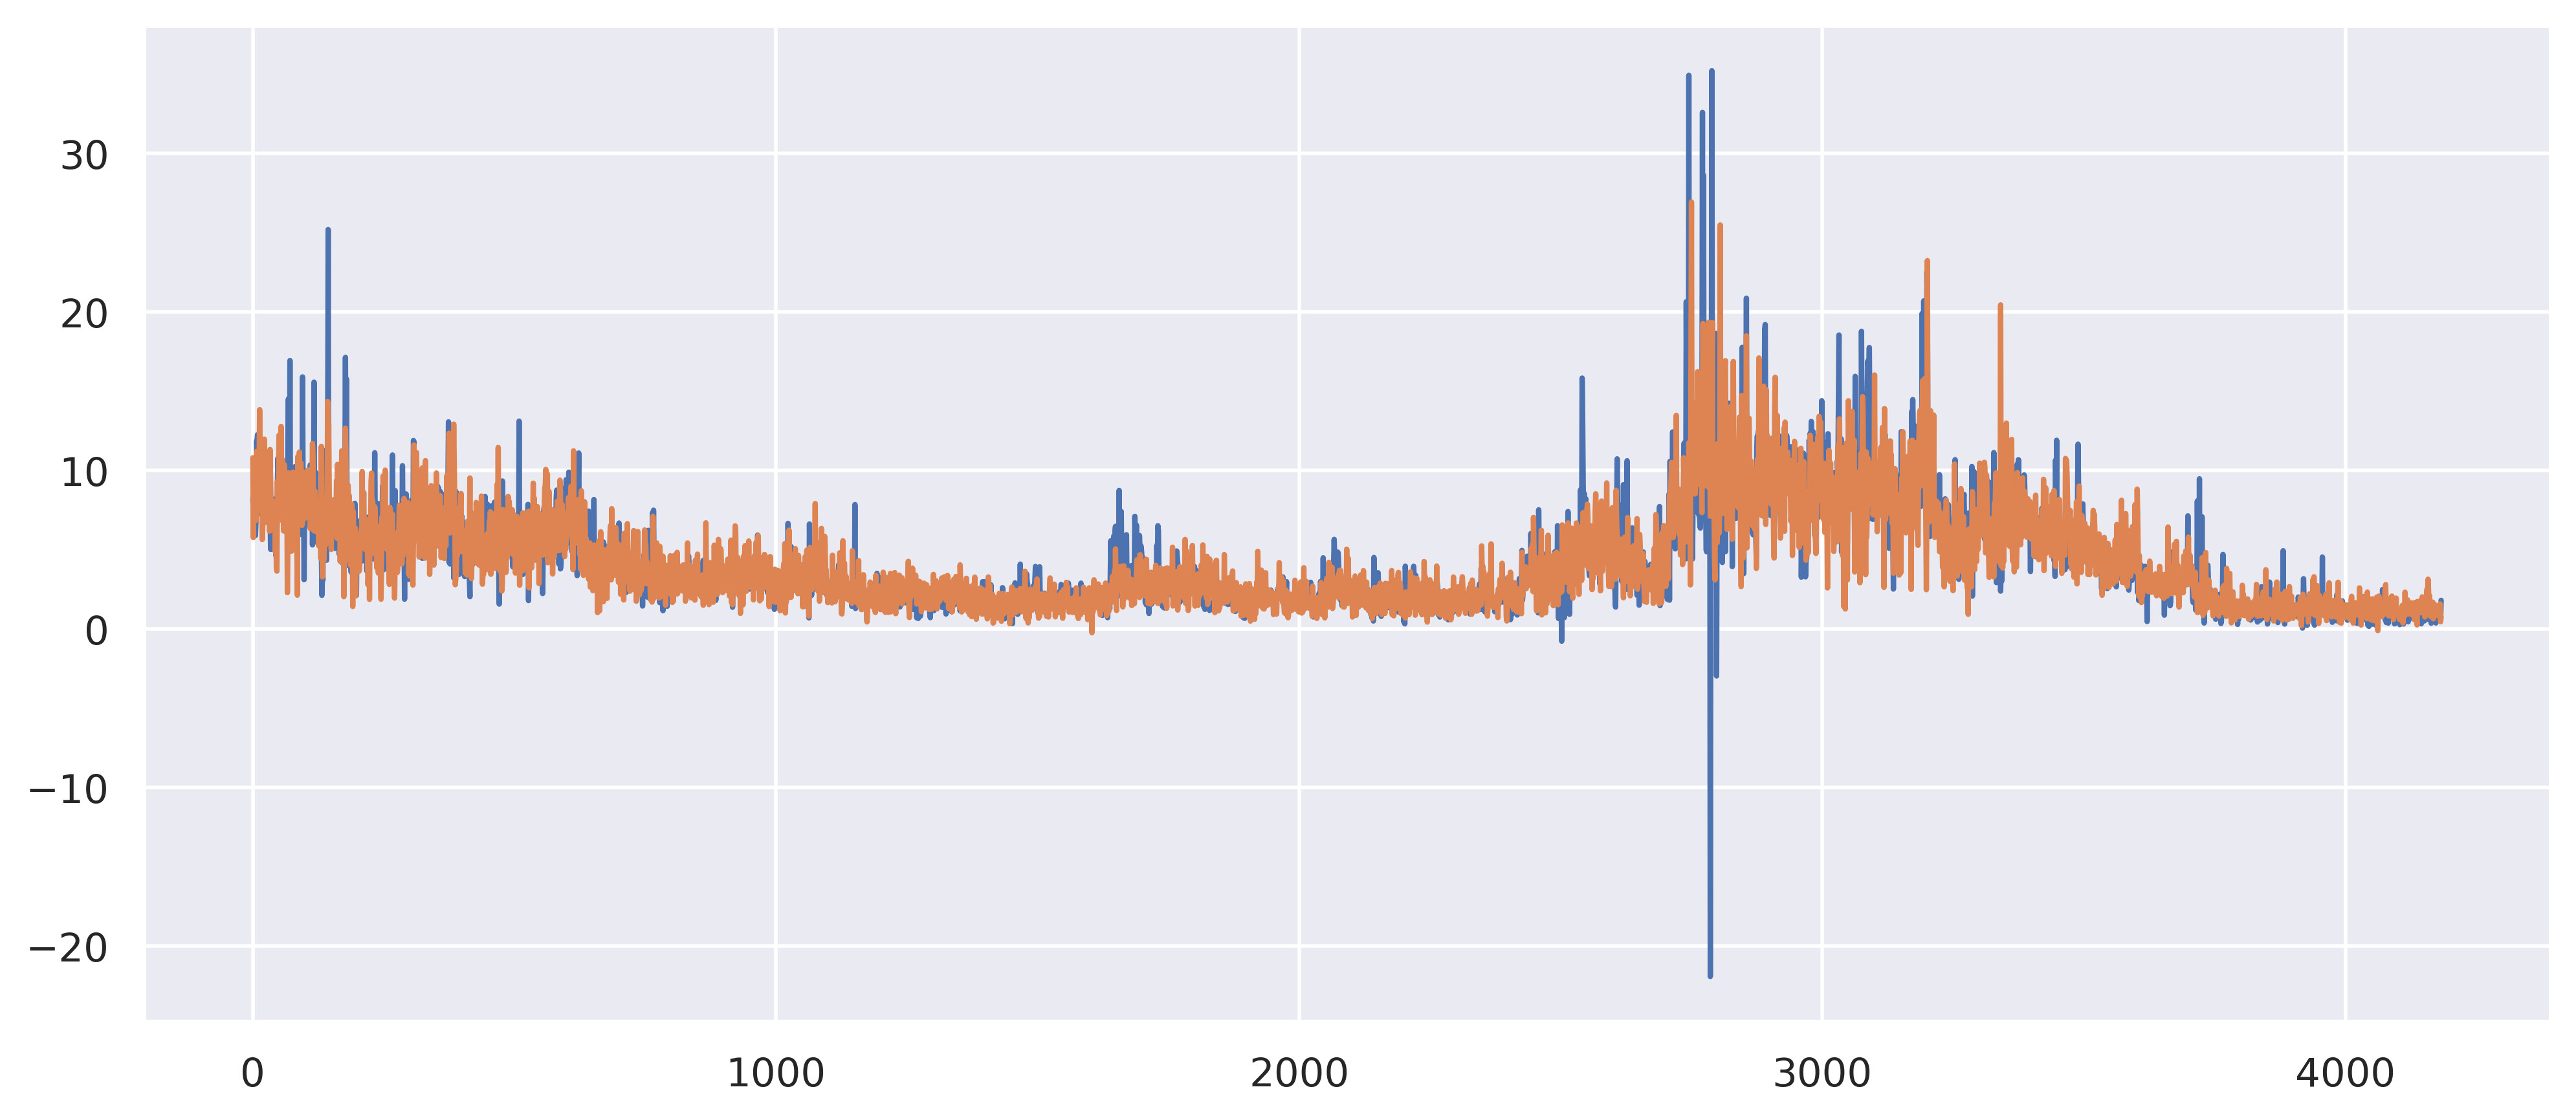

In [55]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt.nee)
ax.plot(preds.nee)
fig.savefig(save_dir.joinpath("nee_predictions.png"))

In [56]:
mask = (test_data["DateTime"].dt.month == 1).values

In [57]:
gt_vis = gt.nee[mask]
preds_vis = preds.nee[mask].flatten()

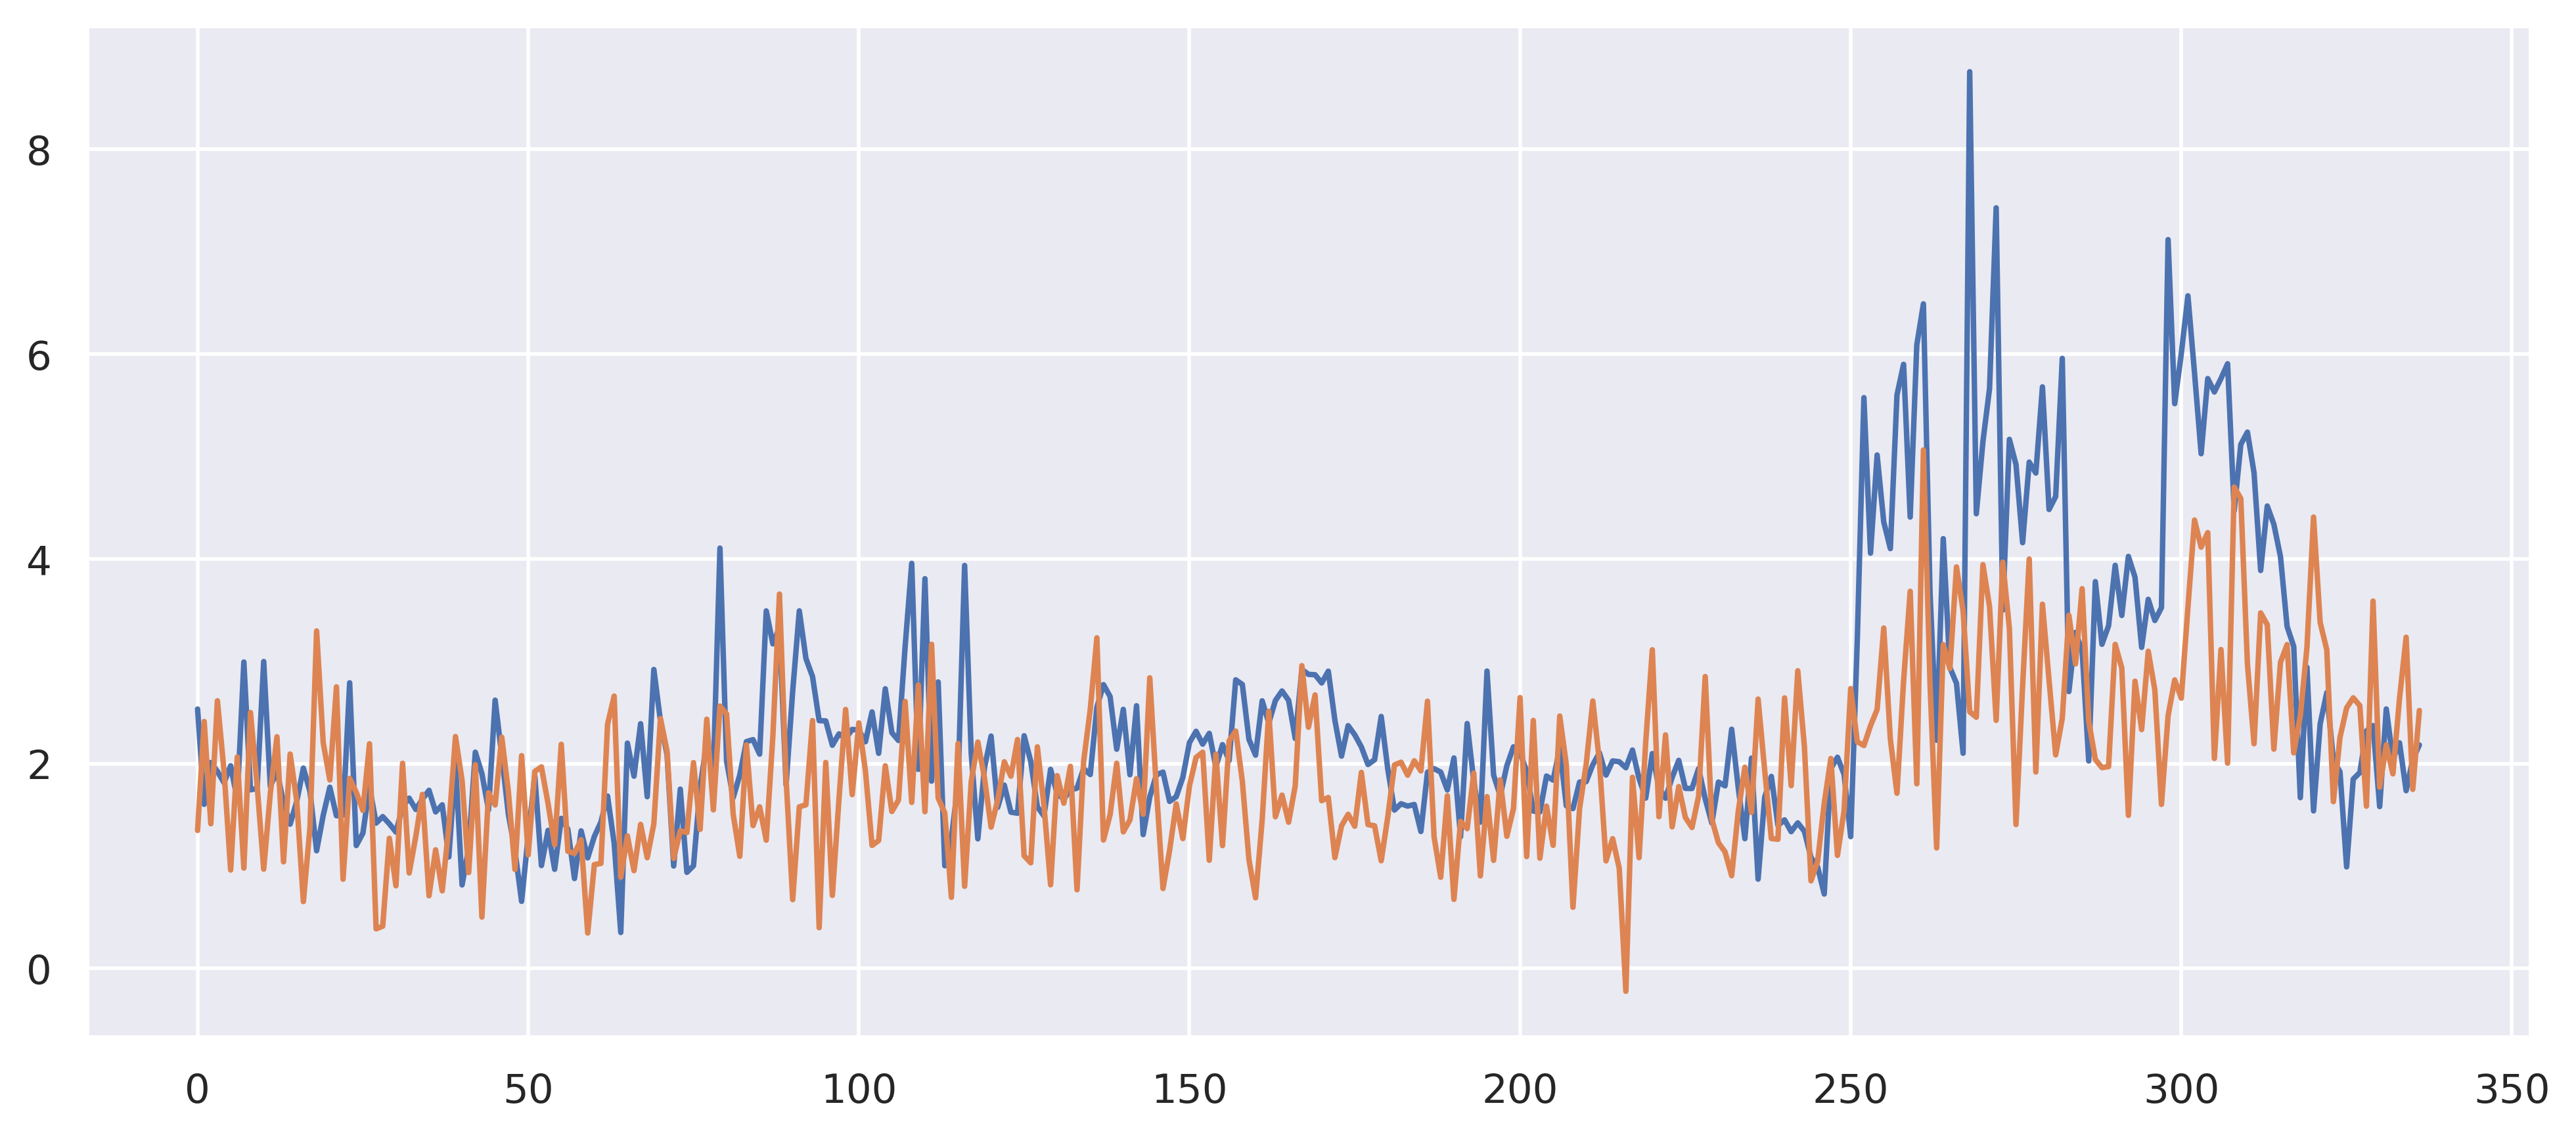

In [58]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis)
ax.plot(preds_vis)
fig.savefig(save_dir.joinpath("nee_predictions_month1.png"))

(0.0, 8.0)

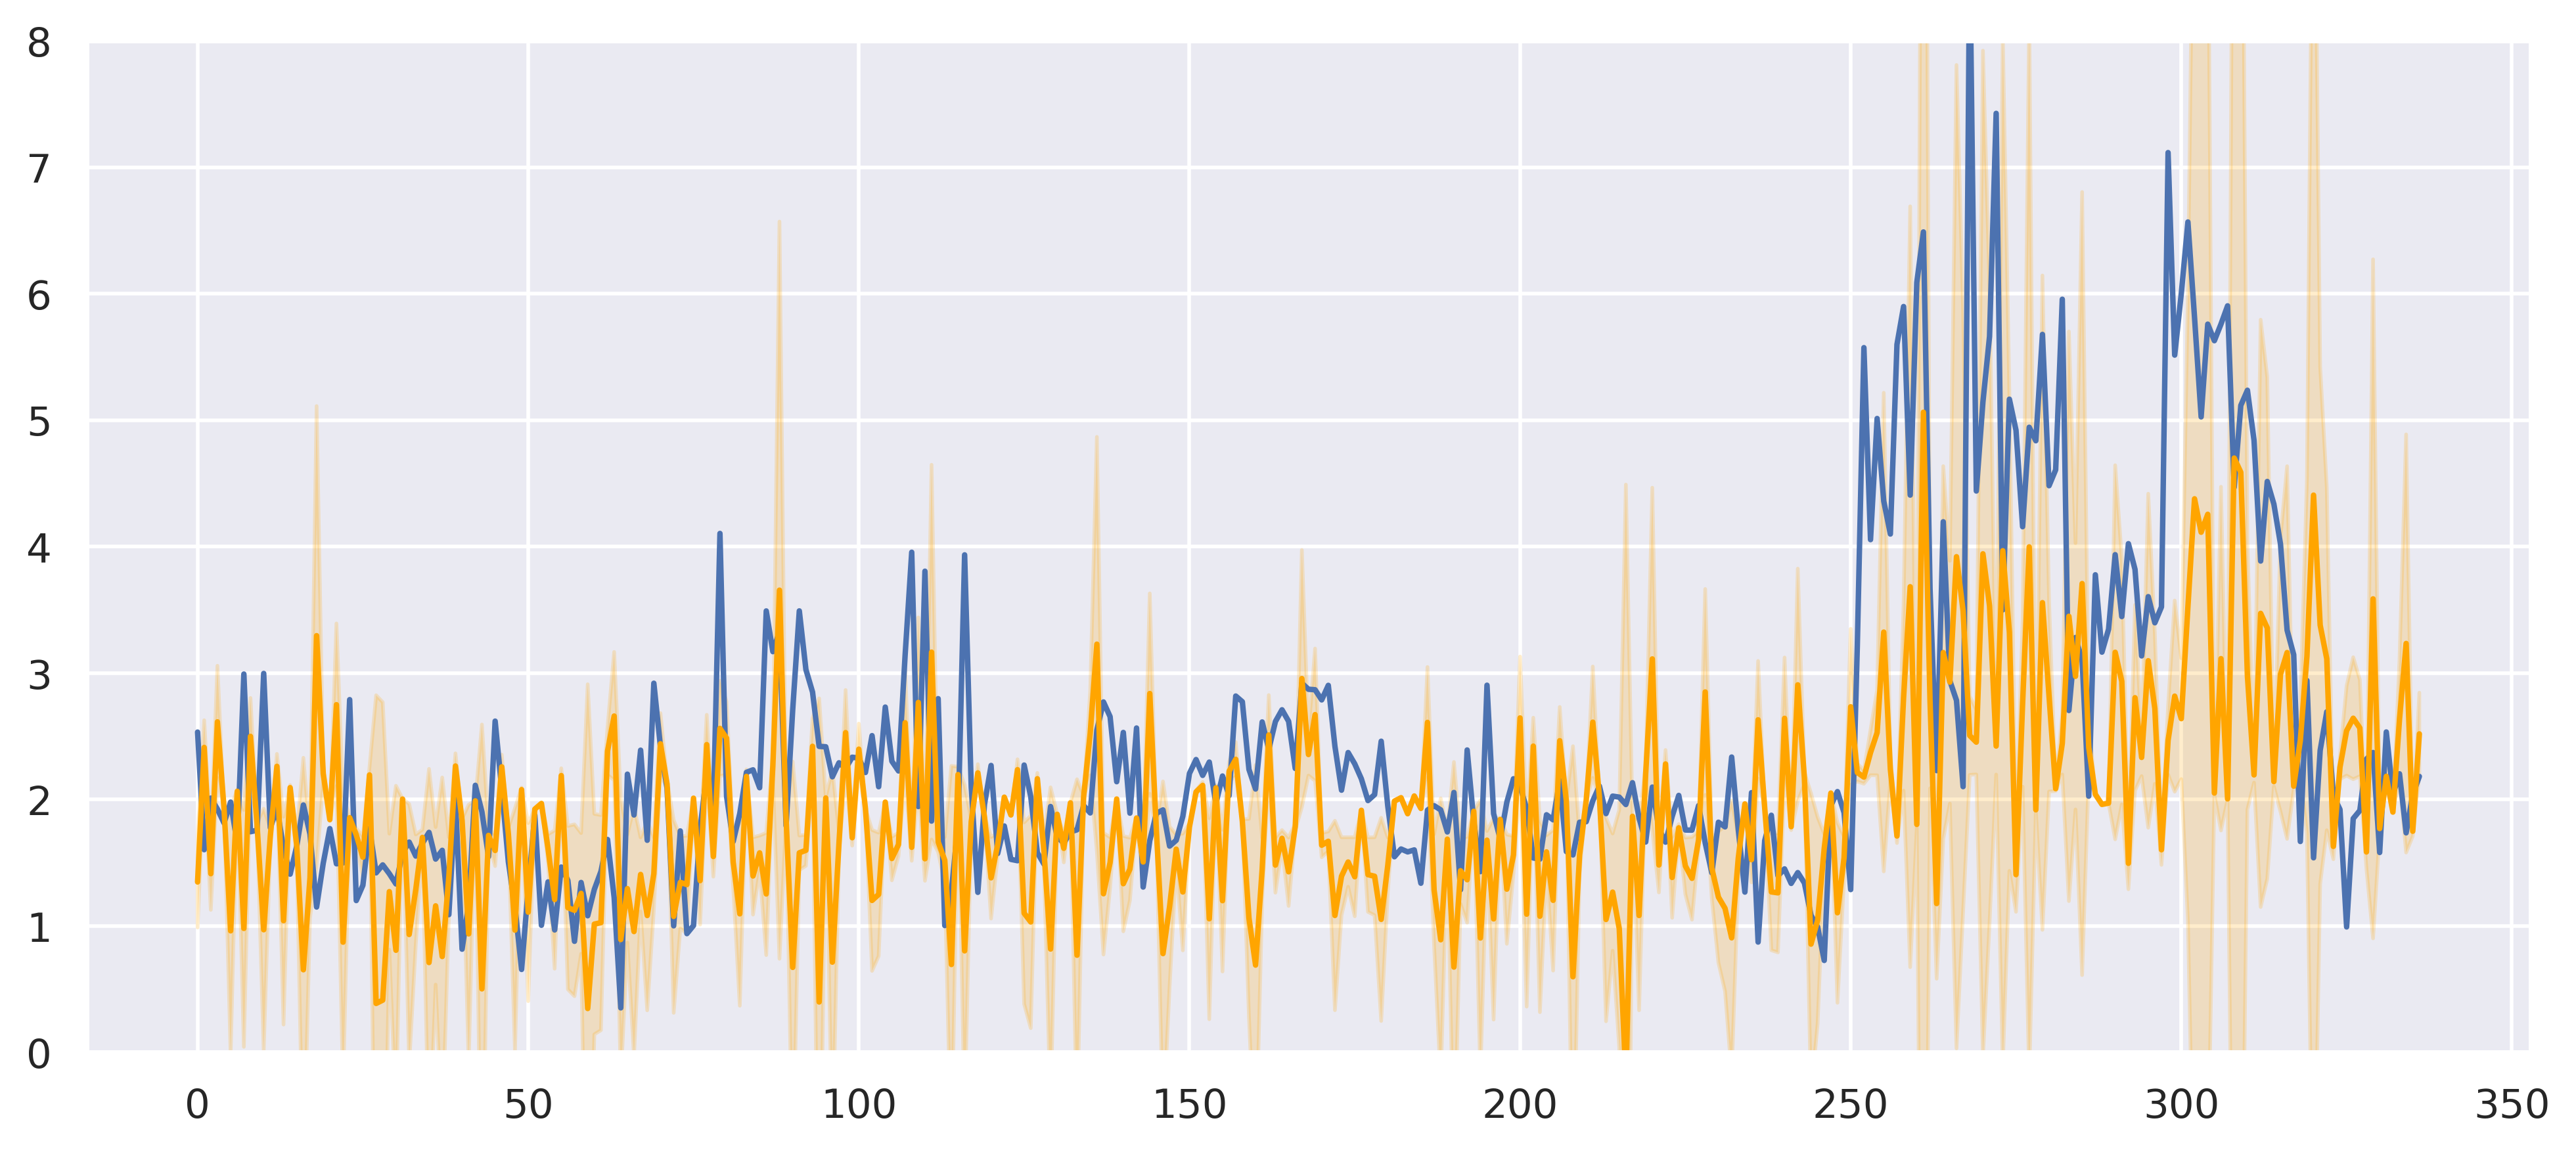

In [59]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
mu = np.mean(preds_vis)
error = np.square(preds_vis - mu)
ax.plot(gt_vis)
ax.plot(preds_vis, color="orange")
ax.fill_between(np.arange(preds_vis.shape[0]), preds_vis - error, preds_vis + error, alpha=0.2, color="orange")

ax.set_ylim(0, 8)